In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from warnings import simplefilter

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# Linear Regression

The linear regression algorithm learns how to make a weighted sum from its input features. For two features, we would have:

    target = weight_1 * feature_1 + weight_2 * feature_2 + bias
    
During training, the regression algorithm learns values for the parameters weight_1, weight_2, and bias that best fit the target. (This algorithm is often called ordinary least squares since it chooses values that minimize the squared error between the target and the predictions.) The weights are also called regression coefficients and the bias is also called the intercept because it tells you where the graph of this function crosses the y-axis.

In [13]:
# Load Dataset
tunnel = pd.read_csv('Datasets/TSData/tunnel.csv', parse_dates=['Day'])
tunnel = tunnel.set_index('Day')

In [15]:
# By default, Pandas creates a `DatetimeIndex` with dtype `Timestamp`
# (equivalent to `np.datetime64`, representing a time series as a
# sequence of measurements taken at single moments. A `PeriodIndex`,
# on the other hand, represents a time series as a sequence of
# quantities accumulated over periods of time. Periods are often
# easier to work with, so that's what we'll use in this course.
tunnel = tunnel.to_period()

In [18]:
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


## Time-Step

Provided the time series doesn't have any missing dates, we can create a time dummy by counting out the length of the series.

In [21]:
from sklearn.linear_model import LinearRegression

In [19]:
df = tunnel.copy()

df['Time'] = np.arange(len(tunnel.index))

In [20]:
df.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


In [22]:
# Training Data
X = df.loc[:, ['Time']] # features
y = df.loc[:, 'NumVehicles'] # target

In [23]:
# Train the Model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [24]:
# Store fitted values as a time series
y_pred = pd.Series(model.predict(X), index=X.index)

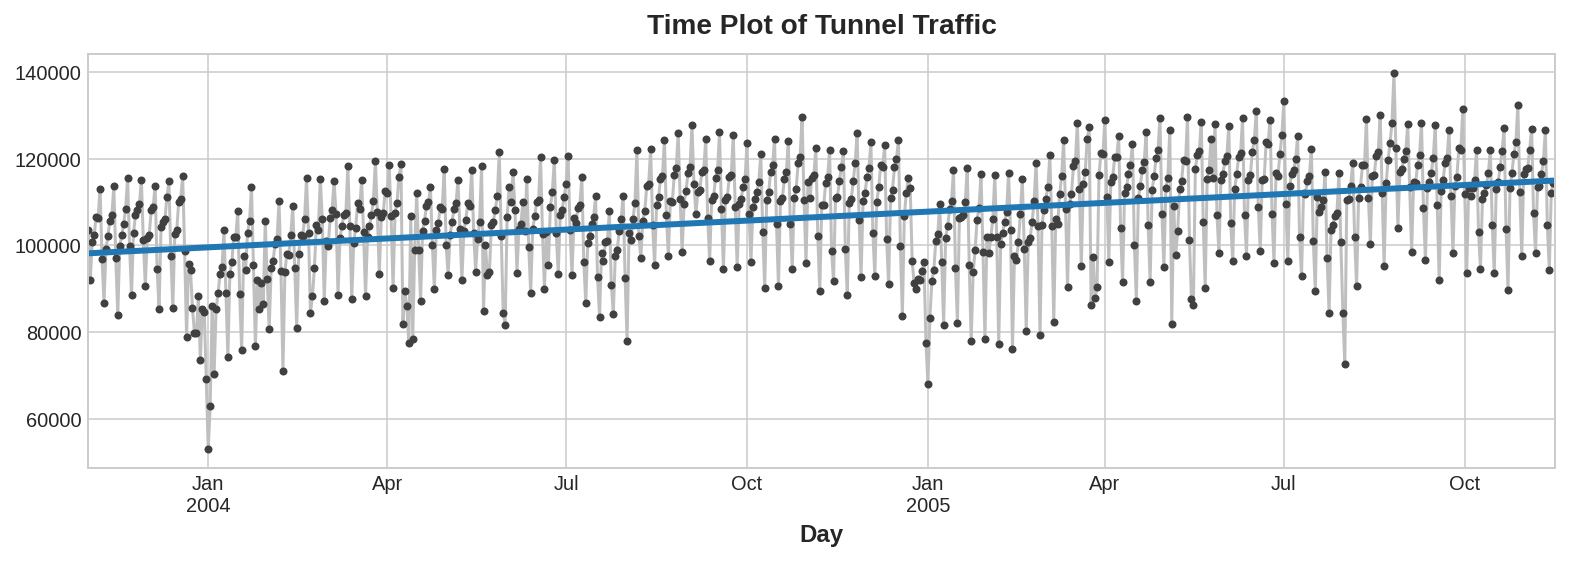

In [27]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

## Lag Feature

When creating lag features, we need to decide what to do with the missing values produced. Filling them in is one option, maybe with 0.0 or "backfilling" with the first known value. Instead, we'll just drop the missing values, making sure to also drop values in the target from corresponding dates.

In [31]:
df['Lag_1'] = df['NumVehicles'].shift(1)
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


In [32]:
X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)
y = df.loc[:, 'NumVehicles']
y, X = y.align(X, join='inner')

In [33]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [34]:
y_pred = pd.Series(model.predict(X), index=X.index)

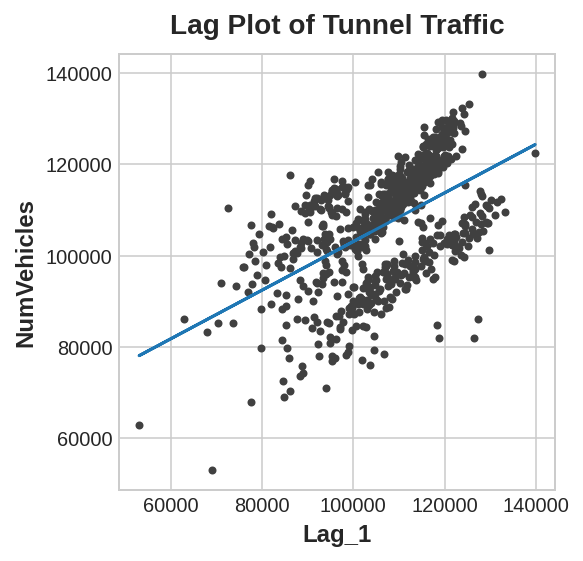

In [35]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic');

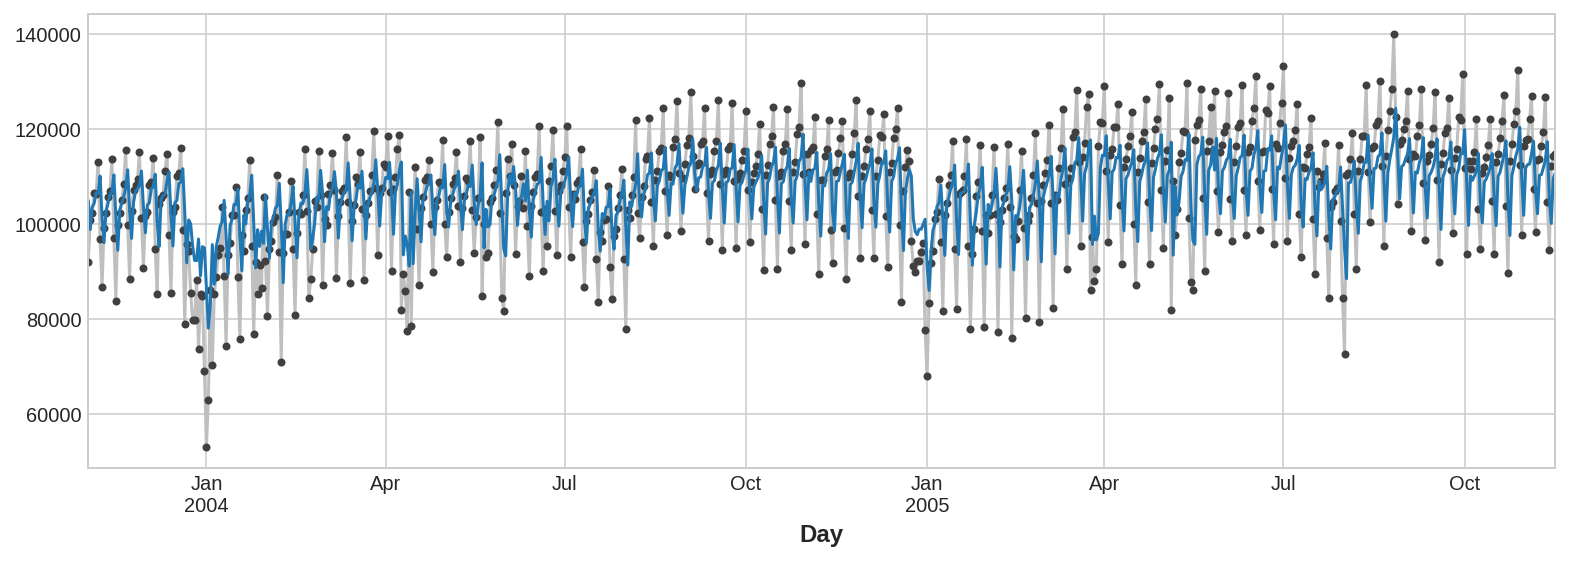

In [36]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

The best time series models will usually include some combination of time-step features and lag features!

# Trends

The trend component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance. 

In [ ]:
# Load Dataset
tunnel = pd.read_csv('Datasets/TSData/tunnel.csv', parse_dates=['Day'])
tunnel = tunnel.set_index('Day')

In [61]:
moving_average = tunnel.rolling(
    window=365,
    center=True,
    min_periods = 183).mean()

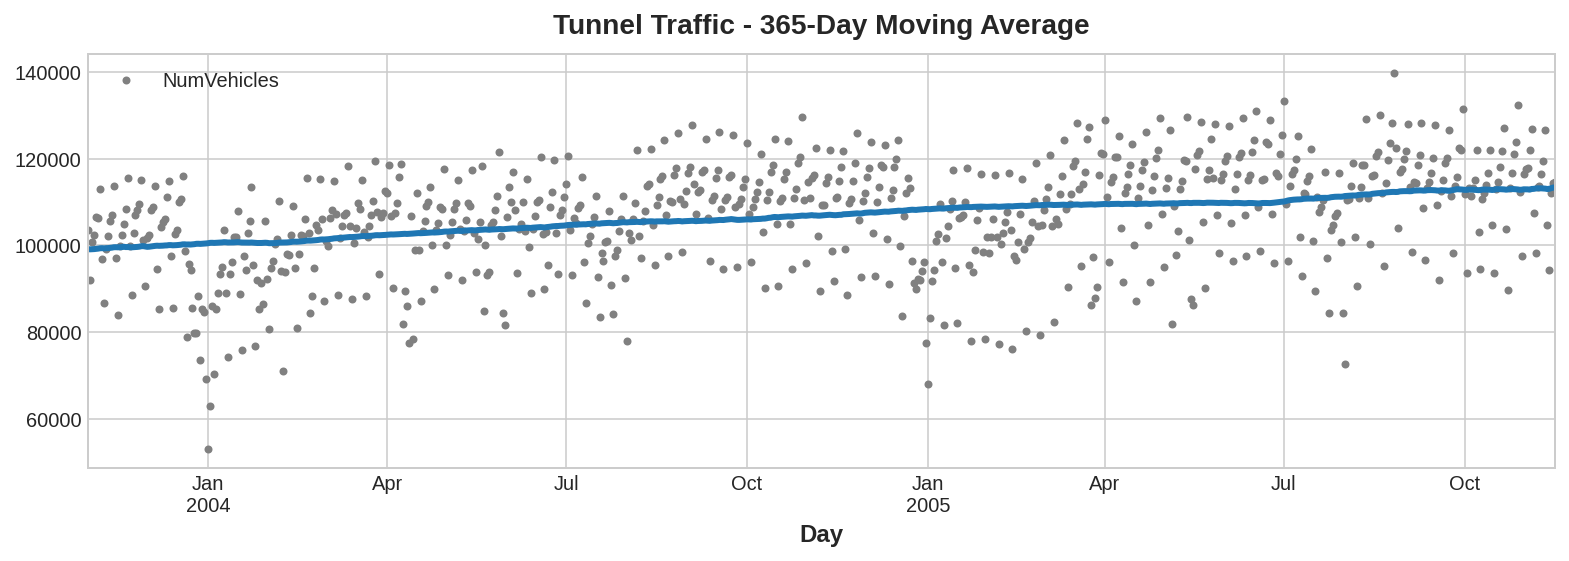

In [62]:
ax = tunnel.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

In [63]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


In [43]:
from sklearn.linear_model import LinearRegression

In [45]:
# Target
y = tunnel.NumVehicles

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

LinearRegression(fit_intercept=False)

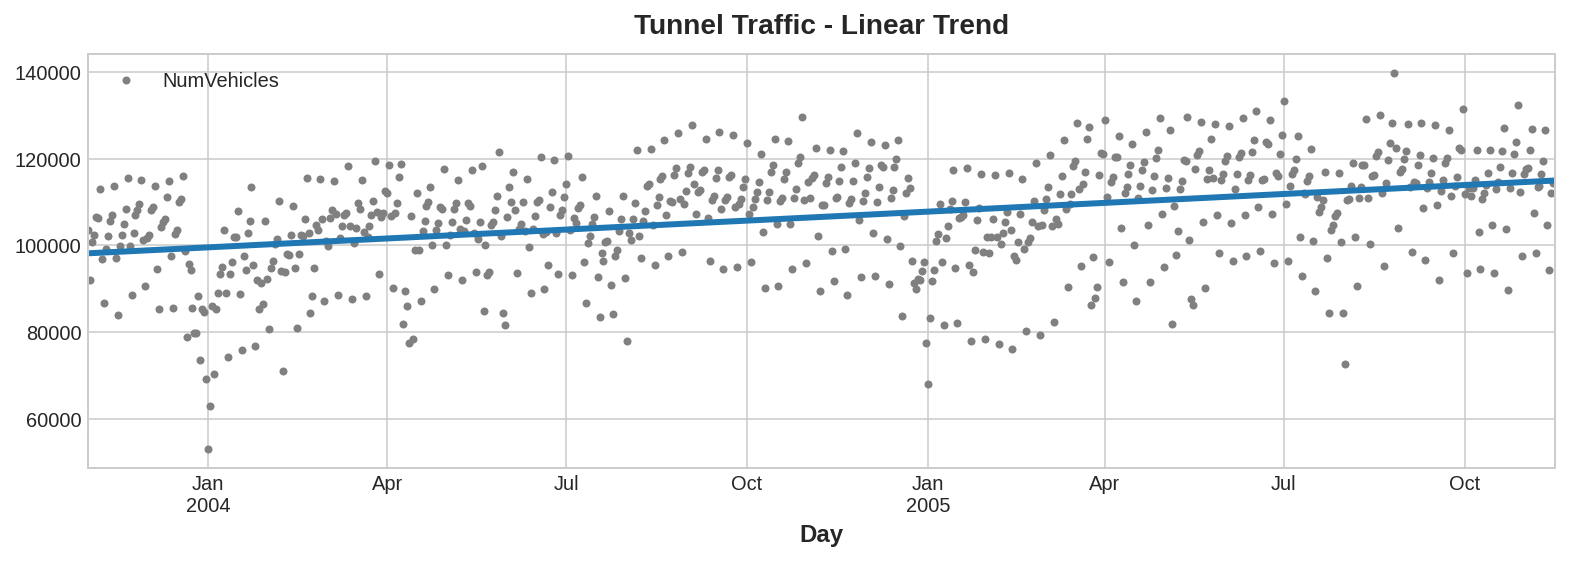

In [47]:
y_pred = pd.Series(model.predict(X), index=X.index)
ax = tunnel.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

To make a forecast we apply the model to 'out of sample' features

In [72]:
X_fore = dp.out_of_sample(steps=30)

/home/miguelpimentel/.local/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and NumericIndex with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


In [90]:
import datetime as dt

new_index = []
for i in range(1, 31, 1):
    new_index.append(X.index[-1] + dt.timedelta(days=i))

In [94]:
X_fore.index = new_index

In [95]:
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)
y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
dtype: float64

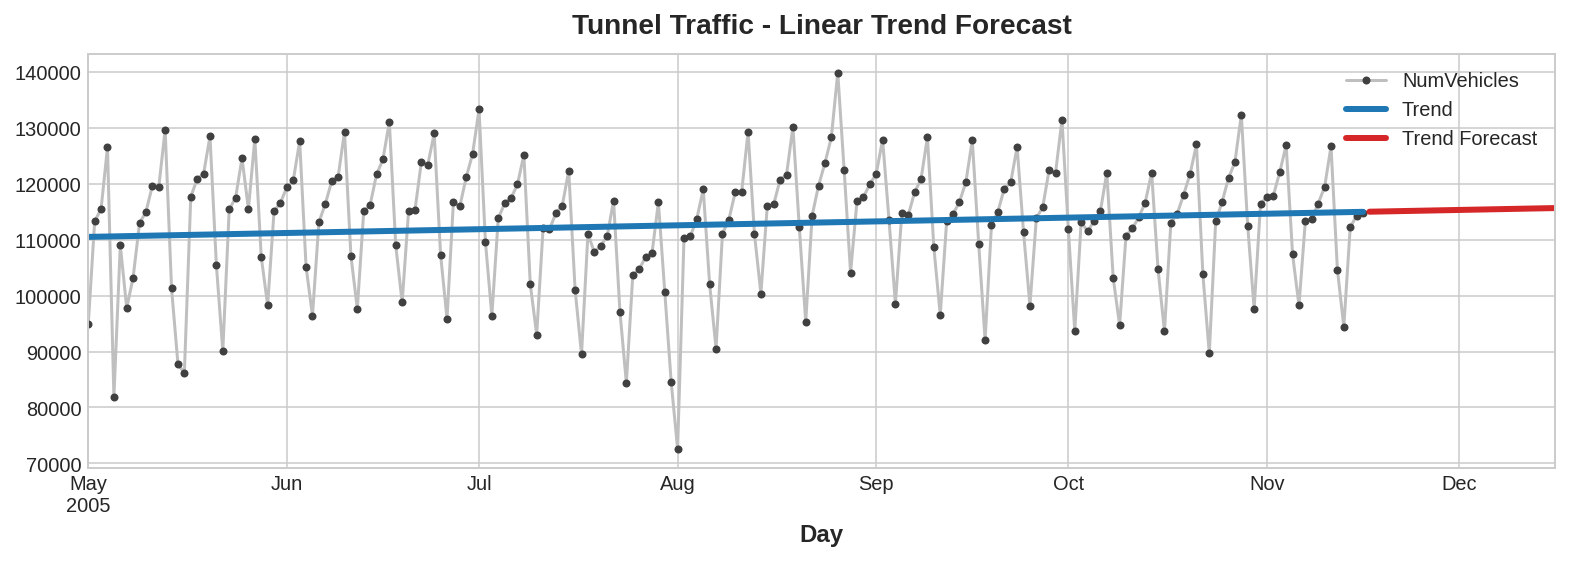

In [96]:
ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

# Seasonality

We say that a time series exhibits seasonality whenever there is a regular, periodic change in the mean of the series. Seasonal changes generally follow the clock and calendar -- repetitions over a day, a week, or a year are common. There are two kinds of features that model seasonality: **Indicators** (best for a season with few observations) and **Fourier features** (best for a season with many observations).

In [25]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression

In [8]:
# Load Dataset
tunnel = pd.read_csv('Datasets/TSData/tunnel.csv', parse_dates=['Day'])
tunnel = tunnel.set_index('Day').to_period("D")

In [14]:
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


## Seasonal Indicators

Seasonal indicators are binary features that represent seasonal differences in the level of a time series. Seasonal indicators are what you get if you treat a seasonal period as a categorical feature and apply one-hot encoding. Adding seasonal indicators to the training data helps models distinguish means within a seasonal period.

The indicators act as On / Off switches. At any time, at most one of these indicators can have a value of 1 (On).

Just like we used a moving average plot to discover the trend in a series, we can use a seasonal plot to discover seasonal patterns. A **seasonal plot** shows segments of the time series plotted against some common period, the period being the "season" you want to observe. 

In [3]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [10]:
X = tunnel.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

In [12]:
X.head()

,NumVehicles,day,week,dayofyear,year
Day,,,,,
2003-11-01,103536,5,44,305,2003
2003-11-02,92051,6,44,306,2003
2003-11-03,100795,0,45,307,2003
2003-11-04,102352,1,45,308,2003
2003-11-05,106569,2,45,309,2003


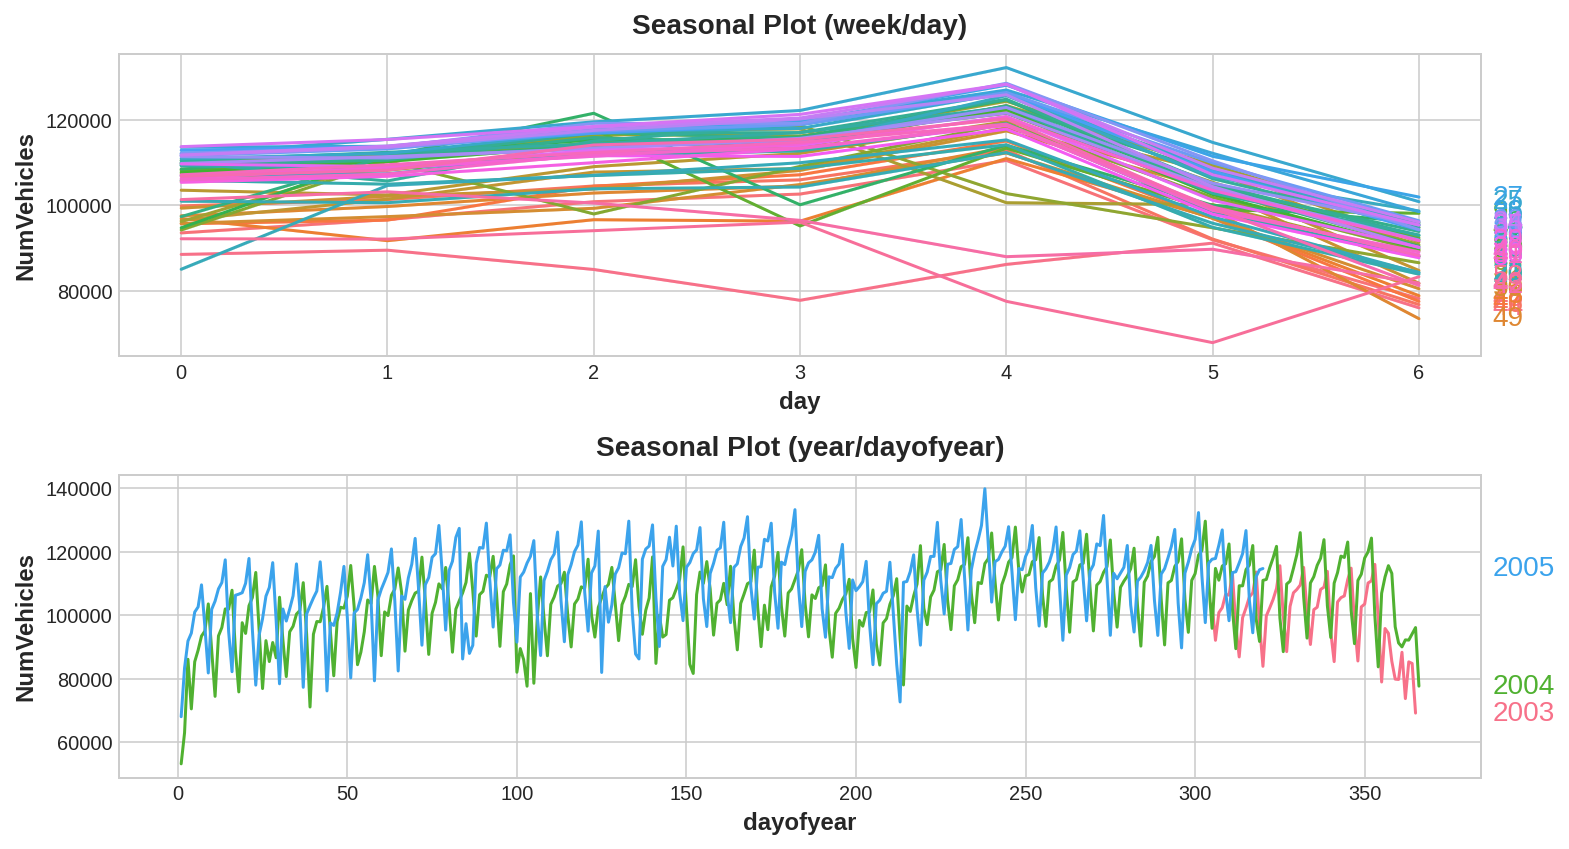

In [13]:
# Let's look at seasonal plots over a week and over a year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="NumVehicles", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="NumVehicles", period="year", freq="dayofyear", ax=ax1);

## Fourier Features

The kind of feature we discuss now are better suited for long seasons over many observations where indicators would be impractical. Instead of creating a feature for each date, Fourier features try to capture the overall shape of the seasonal curve with just a few features.

It is these frequencies within a season that we attempt to capture with Fourier features. The idea is to include in our training data periodic curves having the same frequencies as the season we are trying to model. The curves we use are those of the trigonometric functions sine and cosine.

Fourier features are pairs of sine and cosine curves, one pair for each potential frequency in the season starting with the longest. Fourier pairs modeling annual seasonality would have frequencies: once per year, twice per year, three times per year, and so on. If we add a set of these sine / cosine curves to our training data, the linear regression algorithm will figure out the weights that will fit the seasonal component in the target series.

In [17]:
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)


# Compute Fourier features to the 4th order (8 new features) for a
# series y with daily observations and annual seasonality:

fourier_features(tunnel.NumVehicles, freq=365.25, order=4)

,sin_365.25_1,cos_365.25_1,sin_365.25_2,cos_365.25_2,sin_365.25_3,cos_365.25_3,sin_365.25_4,cos_365.25_4
NumVehicles,,,,,,,,
103536,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
92051,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669,0.068755,0.997634
100795,0.034398,0.999408,0.068755,0.997634,0.103031,0.994678,0.137185,0.990545
102352,0.051584,0.998669,0.103031,0.994678,0.154204,0.988039,0.204966,0.978769
106569,0.068755,0.997634,0.137185,0.990545,0.204966,0.978769,0.271777,0.962360
...,...,...,...,...,...,...,...,...
104646,0.196540,0.980496,0.385413,0.922744,0.559252,0.828998,0.711275,0.702914
94424,0.213377,0.976970,0.416925,0.908941,0.601269,0.799047,0.757921,0.652346
112165,0.230151,0.973155,0.447944,0.894061,0.641688,0.766966,0.800980,0.598692


The **periodogram** tells you the strength of the frequencies in a time series. Specifically, the value on the y-axis of the graph is (a ** 2 + b ** 2) / 2, where a and b are the coefficients of the sine and cosine at that frequency 

In [9]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

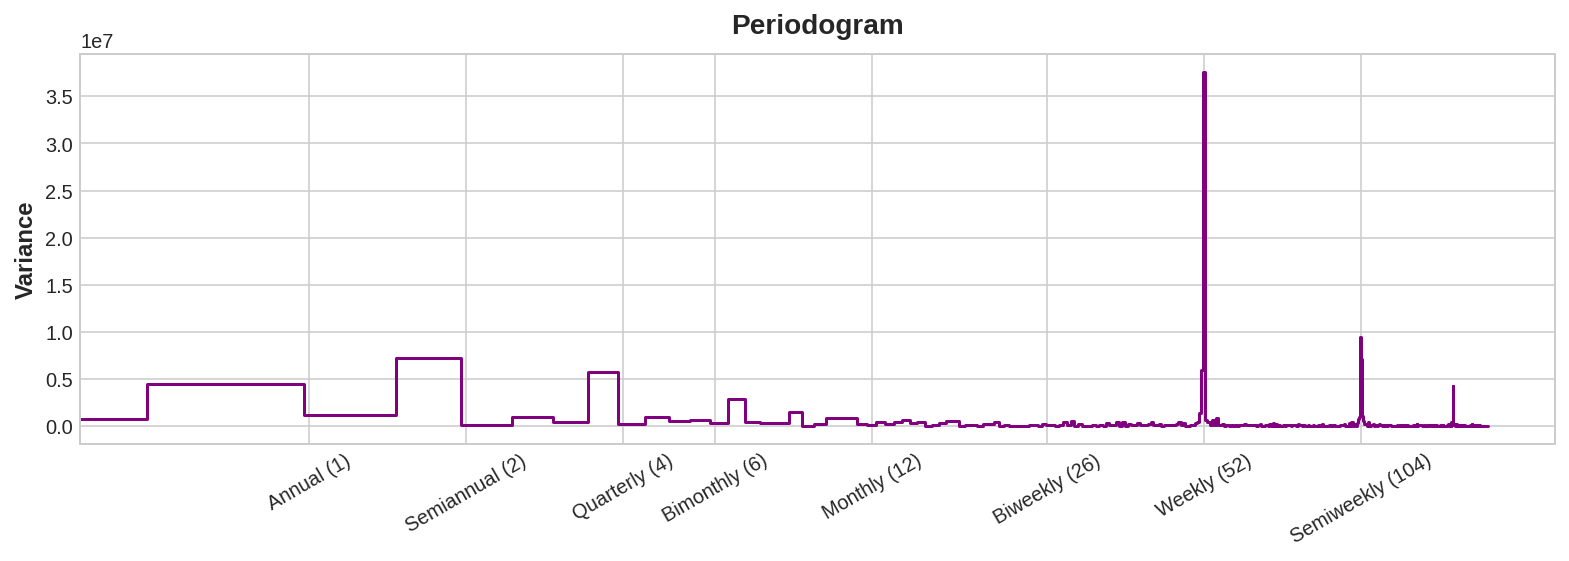

In [18]:
# Let's look at the periodgram now 
plot_periodogram(tunnel.NumVehicles);

## Creating Seasonal Features

The periodgraam agrees with the seasonal plots --> strong weekly season and weaker annual season. Let's create the seasonal features using DeterministicProcess like used for creating trend features.

In [20]:
fourier = CalendarFourier(freq='A', order=10) # 10 sin/cos pairs for annual seasonality

In [21]:
# To use 2 seasonal periods, we'll need to instantiate one of them as an additional feature
dp = DeterministicProcess(
    index=tunnel.index,
    constant=True,  # dummy features for bias (y-intercept)
    order=1,  # trend (1=linear)
    seasonal=True,  # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True  # drop terms to avoid collinearity
)

In [23]:
# Create features for dates in tunnel.index
X = dp.in_sample()
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
Day,,,,,,,,,,,,,,,,,,,,,
2003-11-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.867456,0.497513,...,-0.017213,0.999852,-0.875892,0.482508,-0.854322,-0.519744,0.025818,-0.999667,0.880012,-0.474951
2003-11-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.858764,0.512371,...,0.085965,0.996298,-0.811539,0.584298,-0.917584,-0.397543,-0.128748,-0.991677,0.785650,-0.618671
2003-11-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.849817,0.527078,...,0.188227,0.982126,-0.735417,0.677615,-0.963471,-0.267814,-0.280231,-0.959933,0.668064,-0.744104
2003-11-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.840618,0.541628,...,0.288482,0.957485,-0.648630,0.761104,-0.991114,-0.133015,-0.425000,-0.905193,0.530730,-0.847541
2003-11-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.831171,0.556017,...,0.385663,0.922640,-0.552435,0.833556,-0.999991,0.004304,-0.559589,-0.828770,0.377708,-0.925925


In [24]:
# Create target variable
y = tunnel['NumVehicles']

In [26]:
# Train and fit model
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

LinearRegression(fit_intercept=False)

In [30]:
# Create seasonal predictions
y_pred = pd.Series(model.predict(X), index=y.index)

# Create a 90-day forecast extrapolating beyond training data
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

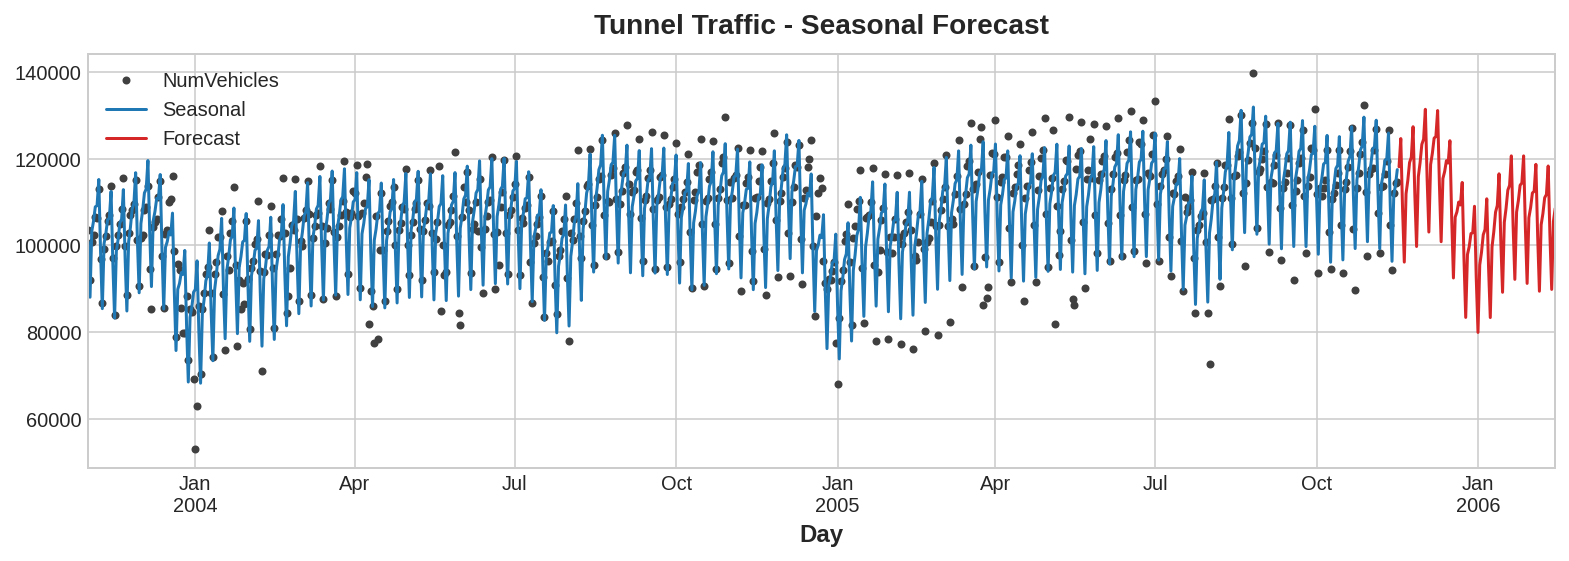

In [33]:
# Plot everything!
ax = y.plot(color='.25', style='.', title='Tunnel Traffic - Seasonal Forecast')
y_pred.plot(ax=ax, label='Seasonal')
y_fore.plot(ax=ax, label='Forecast', color='C3')
ax.legend()

In [88]:
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Time Series Features

## Serial Dependence

Some time-series properties, can only be modeled as serially dependent properties, that is, using as features past values of the target series. The structure of these time series may not be apparent from a plot over time; but plotted against past values, however, the structure becomes more clear.

In [35]:
reserve = pd.read_csv(
    "Datasets/TSData/reserve.csv",
    parse_dates={'Date': ['Year', 'Month', 'Day']},
    index_col='Date',
)

reserve.head()

,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
Date,,,,,,,
1954-07-01,NaN,NaN,NaN,0.80,4.6,5.8,NaN
1954-08-01,NaN,NaN,NaN,1.22,NaN,6.0,NaN
1954-09-01,NaN,NaN,NaN,1.06,NaN,6.1,NaN
1954-10-01,NaN,NaN,NaN,0.85,8.0,5.7,NaN
1954-11-01,NaN,NaN,NaN,0.83,NaN,5.3,NaN



Lagging a time series means to shift its values forward one or more time steps, or equivalently, to shift the times in its index backward one or more steps. In either case, the effect is that the observations in the lagged series will appear to have happened later in time.

In [39]:
y = reserve.loc[:, 'Unemployment Rate'].dropna().to_period('M')
df = pd.DataFrame({
    'y': y,
    'y_lag_1': y.shift(1),
    'y_lag_2': y.shift(2),    
})

df.head()

,y,y_lag_1,y_lag_2
Date,,,
1954-07,5.8,NaN,NaN
1954-08,6.0,5.8,NaN
1954-09,6.1,6.0,5.8
1954-10,5.7,6.1,6.0
1954-11,5.3,5.7,6.1


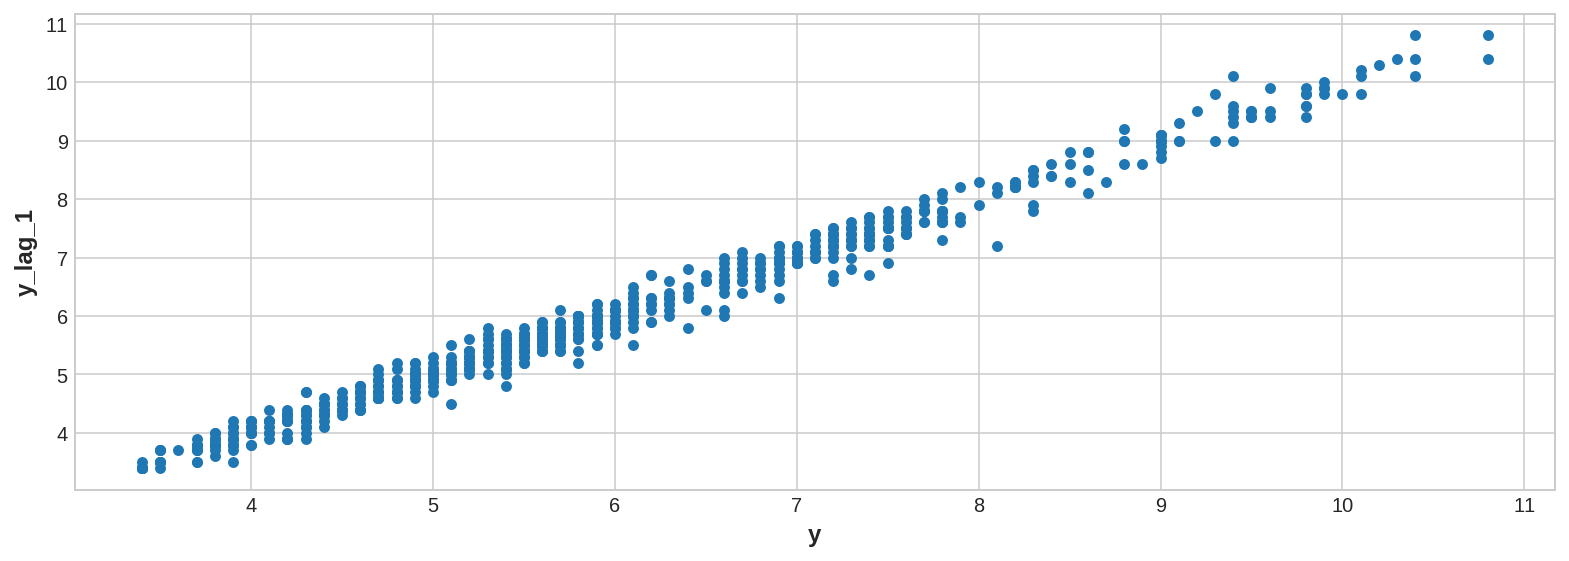

In [45]:
df.plot(x='y', y='y_lag_1', kind='scatter')

## Cycles

Cycles are patterns of growth and decay in a time series associated with how the value in a series at one time depends on values at previous times, but not necessarily on the time step itself. Cyclic behavior is characteristic of systems that can affect themselves or whose reactions persist over time. Economies, epidemics, animal populations, volcano eruptions, and similar natural phenomena often display cyclic behavior. What distinguishes cyclic behavior from seasonality is that cycles are not necessarily time dependent, as seasons are. What happens in a cycle is less about the particular date of occurence, and more about what has happened in the recent past.

In [72]:
flu_trends = pd.read_csv('Datasets/TSData/flu-trends.csv')
flu_trends.set_index(
    pd.PeriodIndex(np.array(flu_trends.Week), freq='W'),
    inplace=True)
flu_trends.drop('Week', axis=1, inplace=True)

In [73]:
flu_trends.head()

,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
2009-06-29/2009-07-05,36,20,43,27,11,22,16,7,3,8,...,16,6,13,25,34,30,25,24,15,180
2009-07-06/2009-07-12,25,19,40,31,10,21,11,6,8,8,...,16,7,8,27,32,27,28,29,9,115
2009-07-13/2009-07-19,24,30,45,20,12,20,20,6,6,8,...,16,6,9,24,28,25,25,25,9,132
2009-07-20/2009-07-26,23,19,40,15,10,19,12,7,10,15,...,8,5,12,21,26,26,29,24,13,109
2009-07-27/2009-08-02,27,21,44,20,11,19,17,8,10,15,...,8,8,12,33,29,21,27,30,9,120


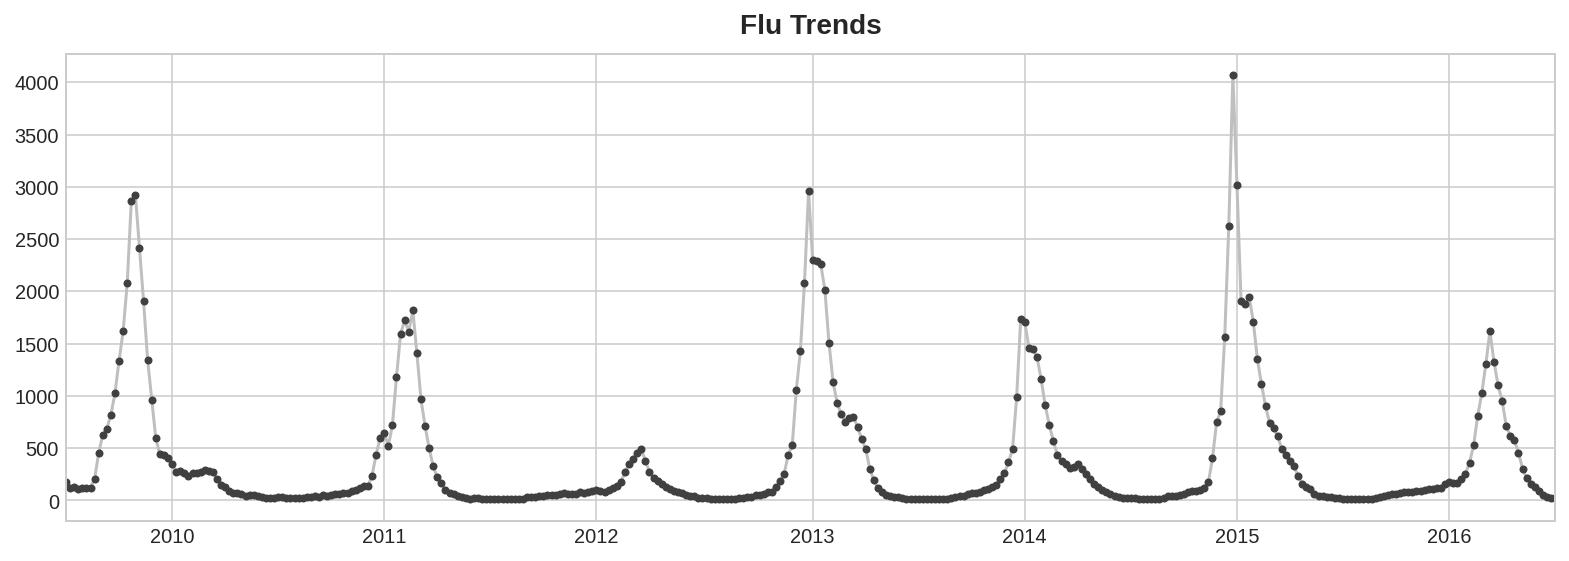

In [76]:
ax = flu_trends.FluVisits.plot(title='Flu Trends', **plot_params)

## Lag Features & Plots

The data shows irregular cycles instead of regular seasonality. Modeling these cycles with lag features will allow the forecaster to react dinamically to changing conditions.

In [80]:
def lagplot(x, y=None, lag=1, standarize=False, ax=None, **kwargs):
    
    from matplotlib.offsetbox import AnchoredText
    
    x_ = x.shift(lag)
    if standarize:
        x_ = (x_ - x_.mean()) / x_.std()
    
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standarize else y
    else:
        y_ = x
        
    corr = y_.corr(x_)
    
    if ax is None:
        fig, ax = plt.subplots()
        
    scatter_kws = dict(alpha=0.75, s=3)
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

In [50]:
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

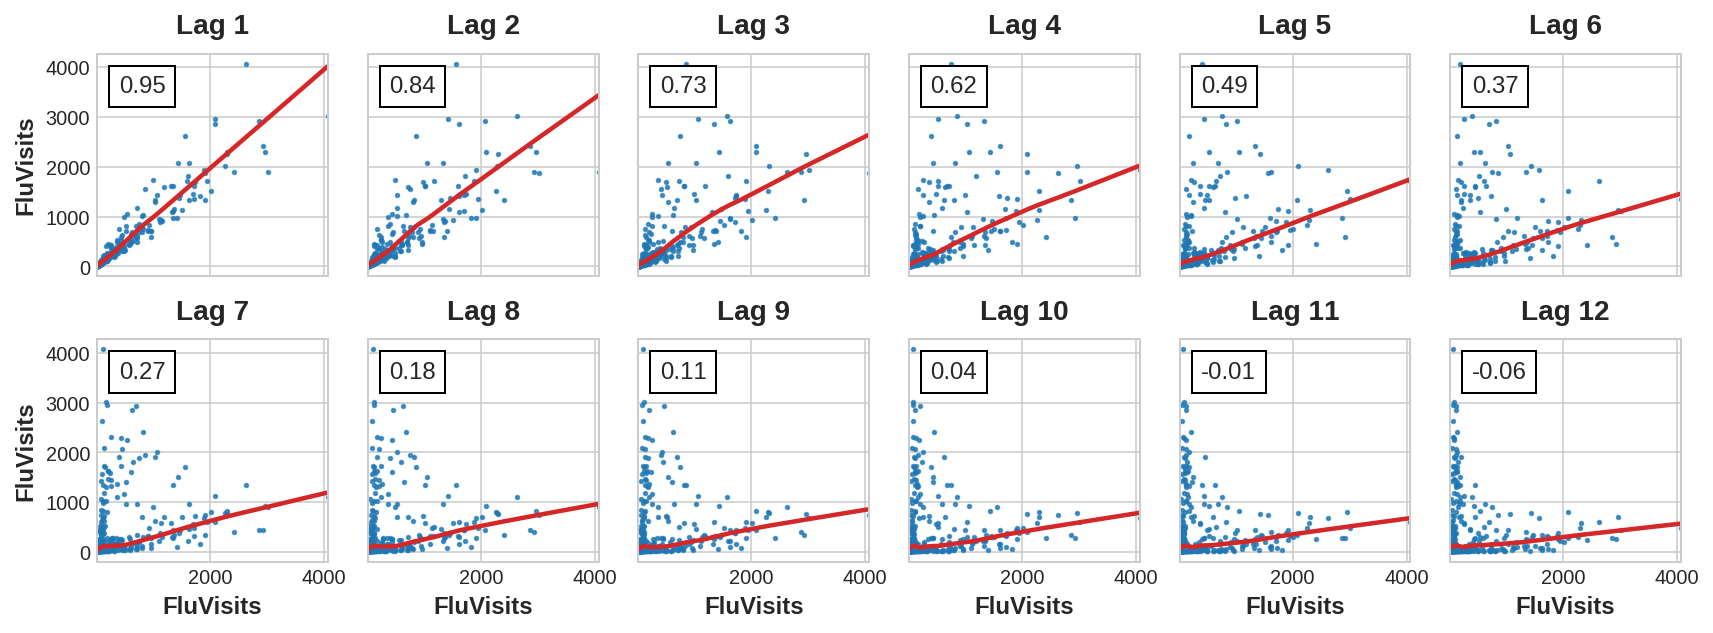

In [82]:
_ = plot_lags(flu_trends.FluVisits, lags=12, nrows=2)

The **partial autocorrelation** tells the correlation of a lag accounting for all previous lags, which can help in choosing which lag features to use, that can be plotted through a correlogram.

/home/miguelpimentel/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


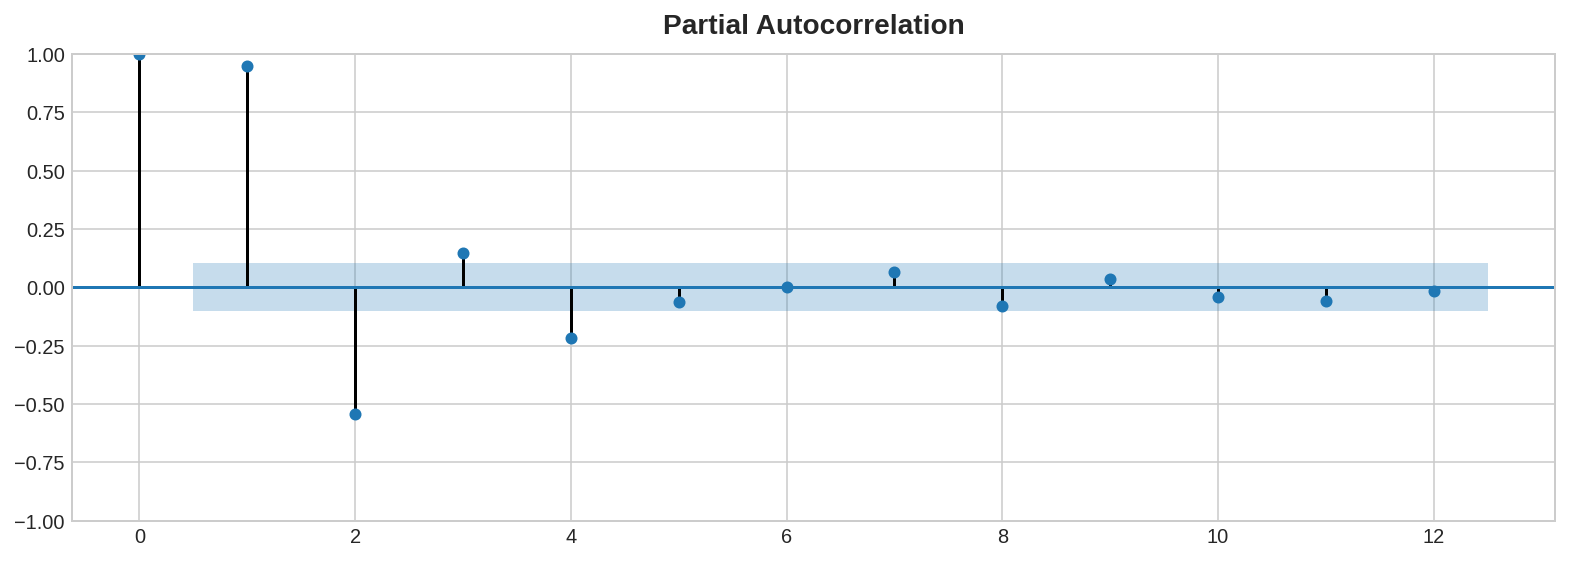

In [83]:
_ = plot_pacf(flu_trends.FluVisits, lags=12)

The plot suggests dependences can be captured using lags 1-4, which can de done using Pandas shift. 

In [85]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags+1)
        },
        axis=1)

In [86]:
X = make_lags(flu_trends.FluVisits, lags=4)
X = X.fillna(0.0)

In [89]:
# Create target series and data splits
y = flu_trends.FluVisits.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

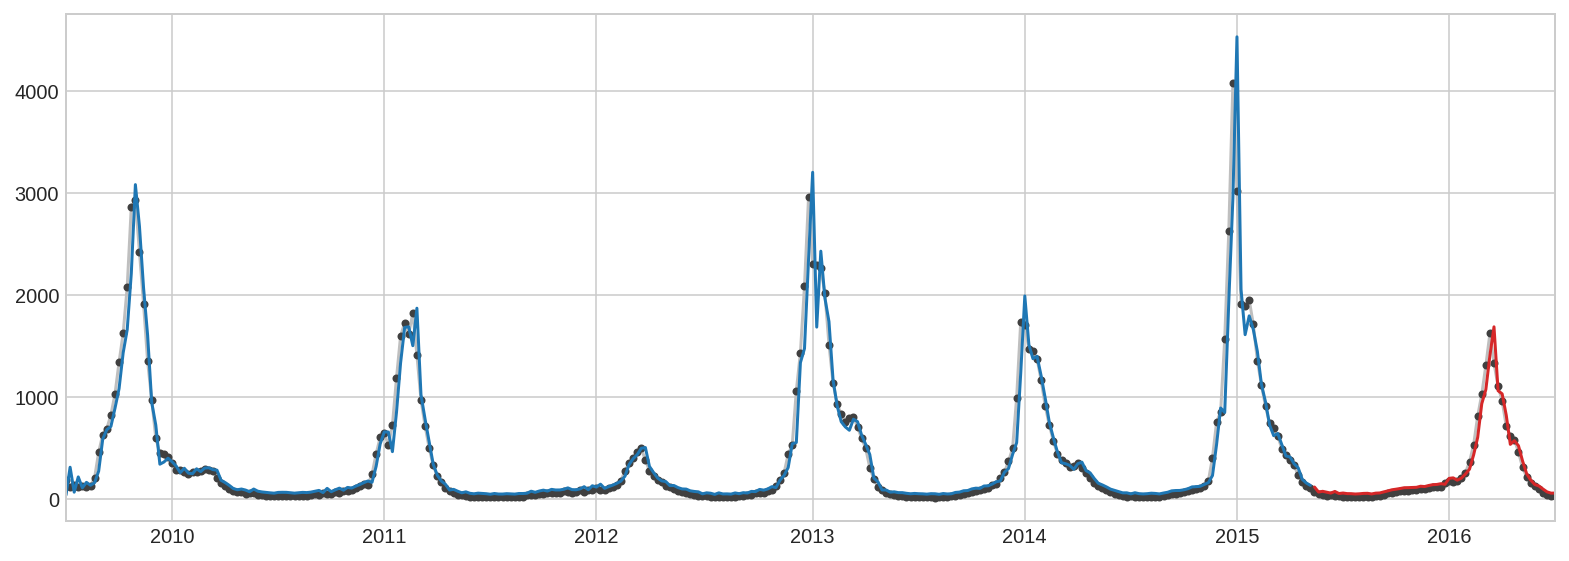

In [94]:
ax = y_train.plot(**plot_params)
y_test.plot(ax=ax, **plot_params)
y_pred.plot(ax=ax)
y_fore.plot(ax=ax, color='C3')

To improve forecast, we will add **leading indicators**

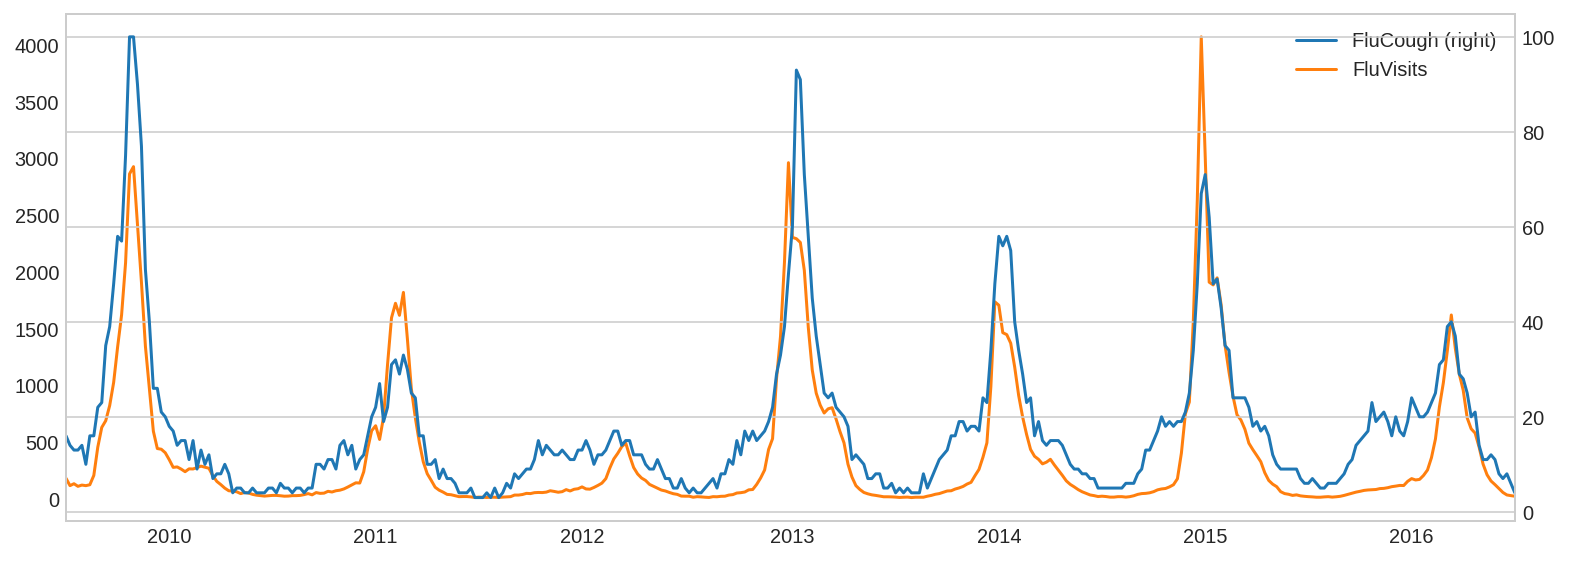

In [95]:
ax = flu_trends.plot(y=['FluCough', 'FluVisits'], secondary_y='FluCough')

## Forecasting Model

In [96]:
search_terms = ["FluContagious", "FluCough", "FluFever", "InfluenzaA", "TreatFlu", "IHaveTheFlu", "OverTheCounterFlu", "HowLongFlu"]

# Create three lags for each search term
X0 = make_lags(flu_trends[search_terms], lags=3)

# Create four lags for the target, as before
X1 = make_lags(flu_trends['FluVisits'], lags=4)

# Combine to create the training data
X = pd.concat([X0, X1], axis=1).fillna(0.0)

/home/miguelpimentel/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/miguelpimentel/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
/home/miguelpimentel/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


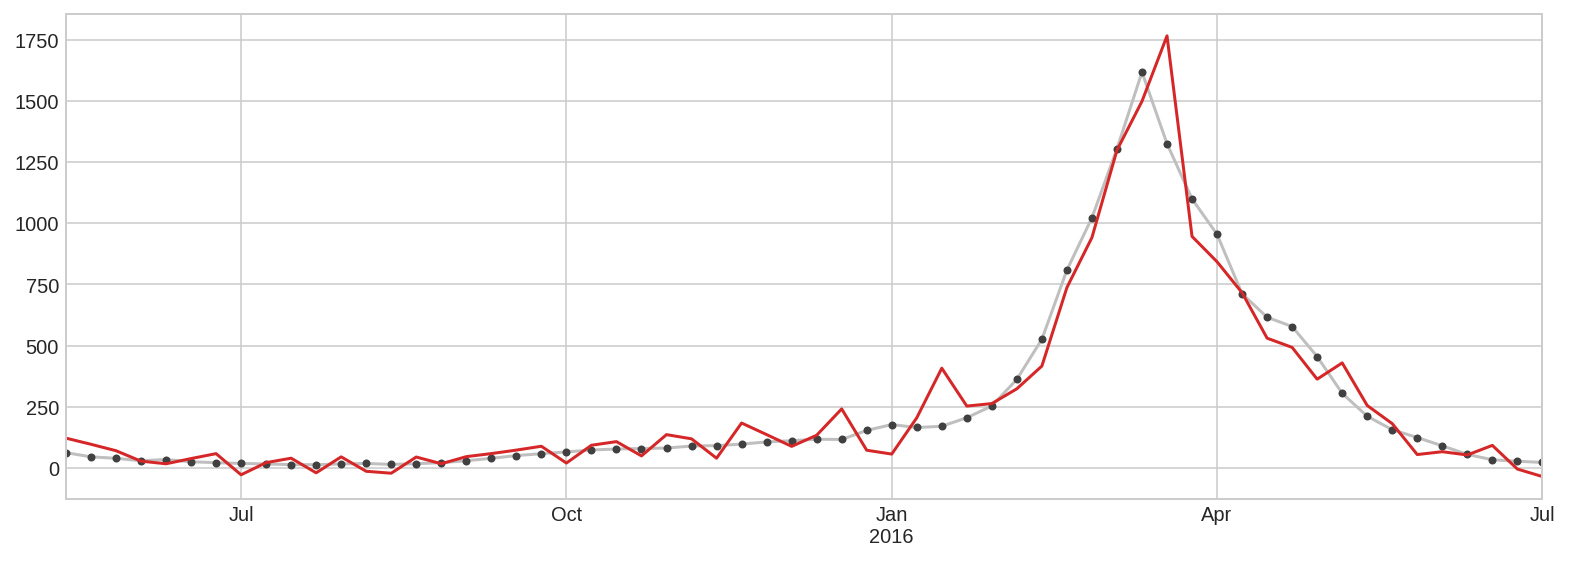

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

# Hybrid Models

Linear Regression excels at extrapolating trends, but can't learn interactions. XGBoost excels at learning interactions, but can't extrapolate trends. Hybrid forecasters combine complementary learning algorithms that let the strengths of one make up for the weakness of the other.

Many time series can be closely described by an additive model:

    series = trend + seasons + cycles + error
    
Each term is a **component** of the series. The **residuals** are the diference between the target the model was trained on and the predictions the model makes (actual curve - fitted curve). The plot of residuals vs. feature is the 'left over' part

In [100]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

In [107]:
industries = ['BuildingMaterials', 'FoodAndBeverage']
retail = pd.read_csv(
    'Datasets/TSData/us-retail-sales.csv',
    usecols = ['Month'] + industries,
    parse_dates = True,
    index_col = 'Month').to_period('D').reindex(columns=industries)
retail = pd.concat({'Sales': retail}, names=[None, 'Industries'], axis=1)

retail.head()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677

## Hybrid Forecasting w/ Residuals

First let's use a linear regression model to learn the trend in each series

In [109]:
y = retail.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data
X.head()

,const,trend,trend_squared
Month,,,
1992-01-01,1.0,1.0,1.0
1992-02-01,1.0,2.0,4.0
1992-03-01,1.0,3.0,9.0
1992-04-01,1.0,4.0,16.0
1992-05-01,1.0,5.0,25.0


In [111]:
# Test on the years 2016-2019. It will be easier for us later if we split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [112]:
# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [113]:
# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

/home/miguelpimentel/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/home/miguelpimentel/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/home/miguelpimentel/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/style.py:60: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  [conv.to_rgba(c) for c in colors]
/home/miguelpimentel/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when

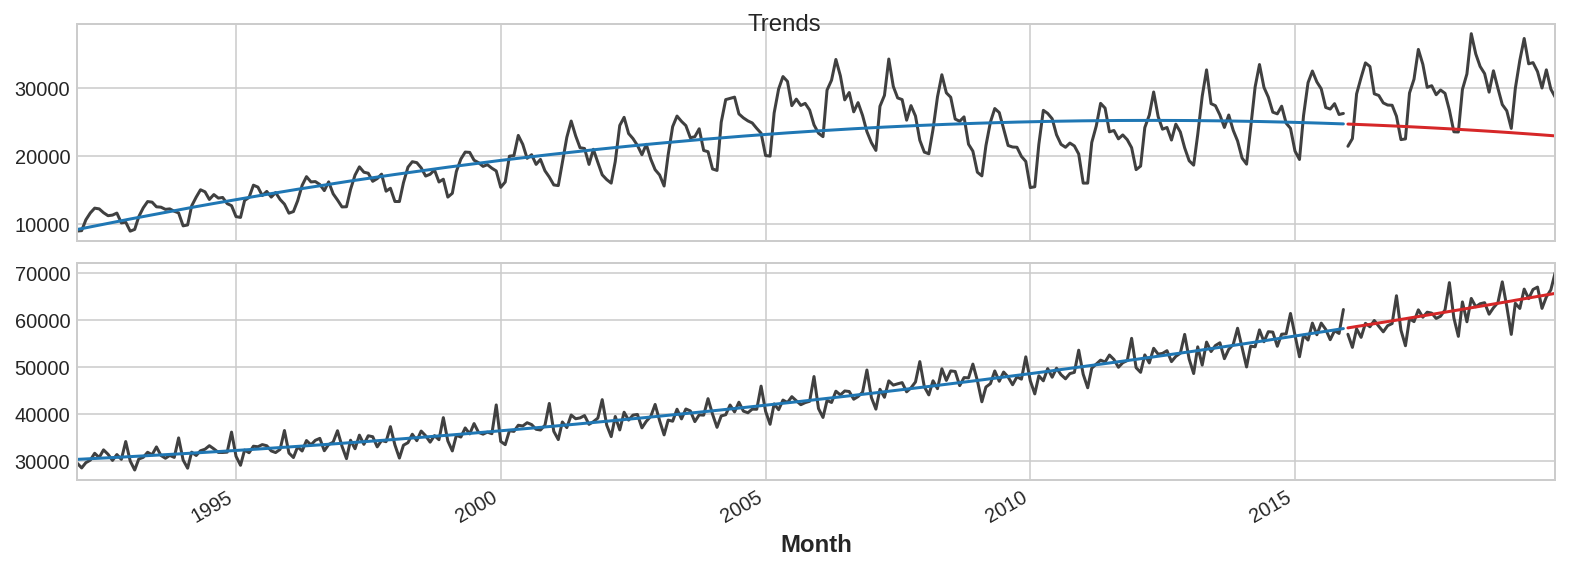

In [114]:
# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [115]:
# The `stack` method converts column labels to row labels, pivoting from wide format to long
X = retail.stack()  # pivot dataset wide to long
display(X.head())
y = X.pop('Sales')  # grab target series

Sales
Month      Industries              
1992-01-01 BuildingMaterials   8964
           FoodAndBeverage    29589
1992-02-01 BuildingMaterials   9023
           FoodAndBeverage    28570
1992-03-01 BuildingMaterials  10608

So that XGBoost can learn to distinguish our two time series, we'll turn the row labels for 'Industries' into a categorical feature with a label encoding. We'll also create a feature for annual seasonality by pulling the month numbers out of the time index.

In [116]:
# Turn row labels into categorical feature columns with a label encoding
X = X.reset_index('Industries')
# Label encoding for 'Industries' feature
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

In [117]:
# Label encoding for annual seasonality
X["Month"] = X.index.month  # values are 1, 2, ..., 12

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

Now we'll convert the trend predictions made earlier to long format and then subtract them from the original series. That will give us detrended (residual) series that XGBoost can learn.

In [118]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

/home/miguelpimentel/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/home/miguelpimentel/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/home/miguelpimentel/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


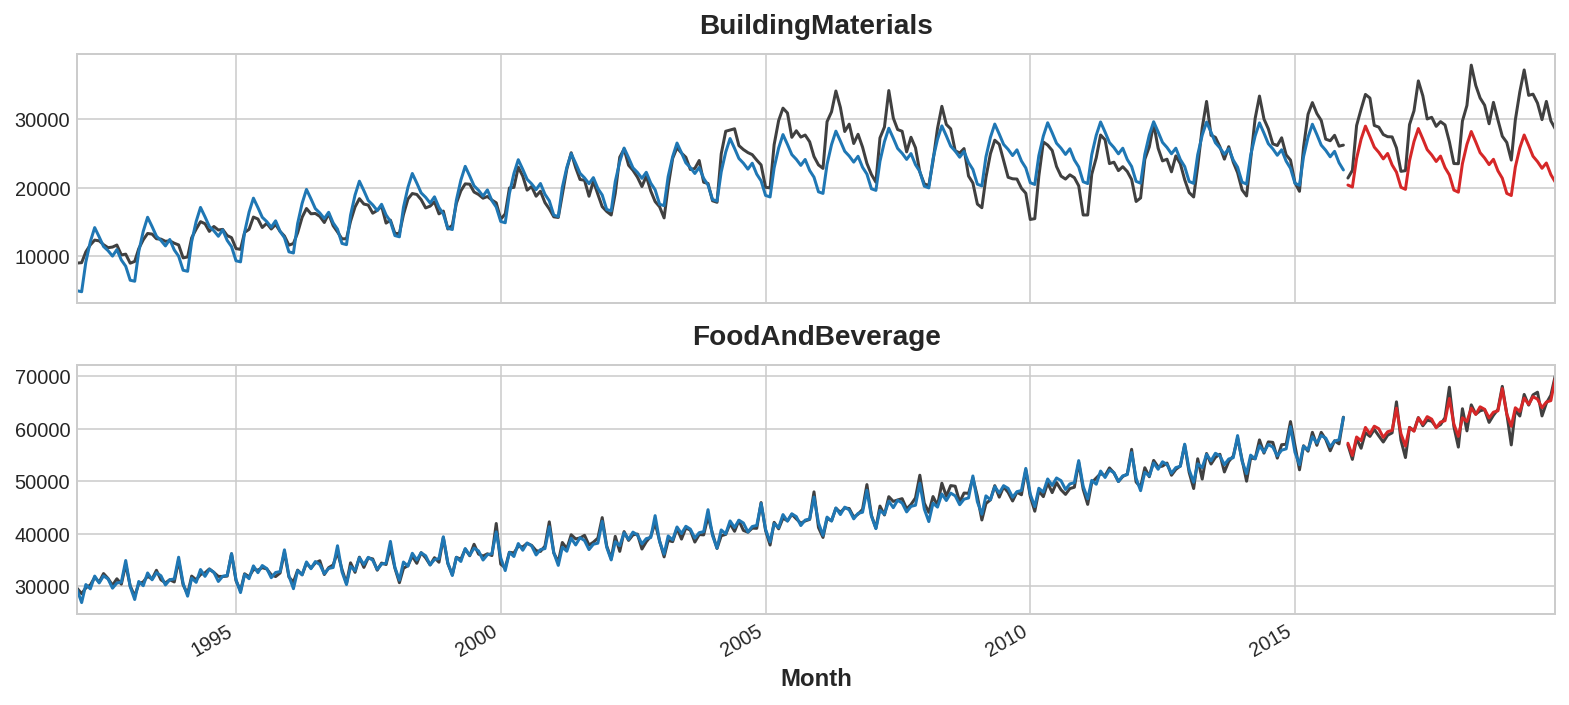

In [119]:
axs = y_train.unstack(['Industries']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['BuildingMaterials', 'FoodAndBeverage'],
)
axs = y_test.unstack(['Industries']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(['Industries']).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(['Industries']).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])

## Boosted Hybrid


It's possible to use one algorithm for some of the components and another algorithm for the rest. This way we can always choose the best algorithm for each component. To do this, we use one algorithm to fit the original series and then the second algorithm to fit the residual series.


    1) Train and Predict w/ first model
    model_1.fit(X_train_1, y_train)
    y_pred_1 = model_1.predict(X_train)

    2) Train and Predict with second model on residuals
    model_2.fit(X_train_2, y_train - y_pred_1)
    y_pred_2 = model_2.predict(X_train_2)

    3) Add to get overall predictions
    y_pred = y_pred_1 + y_pred_2

In [120]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

    def fit(self, X_1, X_2, y):

        self.model_1.fit(X_1, y)

        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, 
            columns=y.columns,
        )

        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze() # wide to long

        self.model_2.fit(X_2, y_resid)

        # Save column names for predict method
        self.y_columns = y.columns
        self.y_fit = y_fit
        self.y_resid = y_resid
    
    def predict(self, X_1, X_2):
        
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, 
            columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()  # wide to long
        y_pred += self.model_2.predict(X_2)

        return y_pred.unstack()  # long to wide

# Forecasting with ML

There are two things to establish before designing a forecasting model:

- What information is available at the time a forecast is made (features);
- The time period during which you require forecasted values (target).
- The **forecast origin** is the time at which you are making a forecast. Practically, you might consider the forecast origin to be the last time for which you have training data for the time being predicted. Everything up to the origin can be used to create features.
- The **forecast horizon** is the time for which you are making a forecast. We often describe a forecast by the number of time steps in its horizon: a "1-step" forecast or "5-step" forecast, say. The forecast horizon describes the target.
- The time between the origin and the horizon is the **lead time** (or sometimes latency) of the forecast. A forecast's lead time is described by the number of steps from origin to horizon:

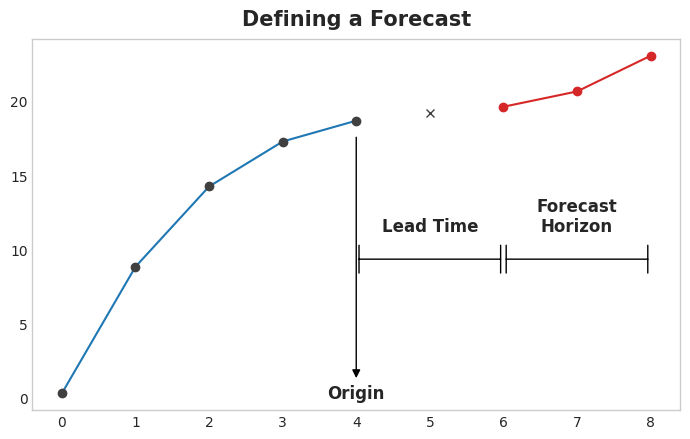

In [121]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [122]:
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

In [123]:
flu_trends = pd.read_csv("Datasets/TSData/flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)

TypeError: Incorrect dtype